In [1]:
import pandas as pd
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer

tqdm.pandas()

In [2]:
model_name = "Qwen/Qwen3-Embedding-0.6B"
model = SentenceTransformer(model_name)
model.half()
tokenizer = AutoTokenizer.from_pretrained(model_name)

## EDA

In [3]:
#df = pd.read_parquet('results_conclusions_585k_2025-01-02.parquet')
df = pd.read_parquet('library_v1_2025-12-08.parquet')

In [4]:
df

,id,doi,title,abstract,language,publication_date,type,has_fulltext,fwci,is_oa,oa_status,landing_page_url,pdf_url
0,W1000221716,None,Integrated management of leafy spurge,Figure 1. Leafy spurge plant in flowering grow...,en,1995-01-01,article,1.0,1.44102389,True,green,http://hdl.handle.net/10365/17688,http://hdl.handle.net/10365/17688
1,W100006350,None,Farm Consolidation in the Northern and Central...,"During the past half century, American agricul...",en,1987-01-01,article,1.0,0.0,True,green,http://digitalcommons.unl.edu/greatplainsquart...,http://digitalcommons.unl.edu/cgi/viewcontent....
2,W1000233381,https://doi.org/10.12736/issn.2300-3022.2013212,The lower Vistula in the aspect of the E40 and...,Throughout the history of Europe and the world...,en,2013-06-03,article,0.0,0.48269519,False,closed,None,None
3,W1000028557,https://doi.org/10.3133/ofr93101,"Occurrence of pesticides, nitrite plus nitrate...","During 1988, pesticides were detected in 4 of ...",en,1993-01-01,article,1.0,0.0,True,bronze,https://doi.org/10.3133/ofr93101,https://pubs.usgs.gov/of/1993/0101/report.pdf
4,W1000134164,https://doi.org/10.3133/sir20055079,Feasibility of using benthic invertebrates as ...,Macroinvertebrates were collected from 19 site...,en,2005-01-01,article,0.0,0.0,False,closed,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2509911,W2112656034,https://doi.org/10.7325/galemys.2012.a05,Habitat suitability model for red deer (Cervus...,Monitoring population trends is essential in w...,en,2012-12-31,article,0.0,0.2588458,False,closed,None,None
2509912,W2159214726,None,Heavy metal concentrations in the topsoils of ...,"In the Dutch part of the area, heavy metal con...",en,2007-01-01,article,0.0,0.0,False,closed,None,None
2509913,W266132455,None,Determination of the upper threshold value for...,Using reclaimed water for greenbelt irrigation...,en,2009-01-01,article,0.0,0.0,False,closed,None,None
2509914,W4405528638,https://doi.org/10.20944/preprints202412.1402.v1,UV Map Nowcasting and Comparison with Ground-B...,This study introduces a new method for nowcast...,en,2024-12-18,preprint,0.0,0.0,True,green,https://doi.org/10.20944/preprints202412.1402.v1,None


In [5]:
def count_tokens(s):
    tokens = tokenizer.encode(s)
    return len(tokens)

In [6]:
sample = df.sample(10_000)

In [7]:
#sample['results_tokens'] = sample['results'].progress_apply(count_tokens)
sample['abstract_tokens'] = sample['abstract'].progress_apply(count_tokens)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [27]:
sample['discussion_tokens'] = sample['discussion'].progress_apply(count_tokens)
sample['total_tokens'] = sample['results_tokens'] + sample['discussion_tokens']

  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
sample['abstract_tokens'].describe()
#sample['discussion_tokens'].describe()

count    10000.000000
mean       306.498200
std        201.392646
min          8.000000
25%        197.000000
50%        271.000000
75%        371.000000
max       6163.000000
Name: abstract_tokens, dtype: float64

In [34]:
sample['results_tokens'].describe()

count     10000.000000
mean       2308.537600
std        5380.754951
min           1.000000
25%         109.000000
50%        1700.000000
75%        3131.000000
max      414556.000000
Name: results_tokens, dtype: float64

array([[<Axes: title={'center': 'abstract_tokens'}>]], dtype=object)

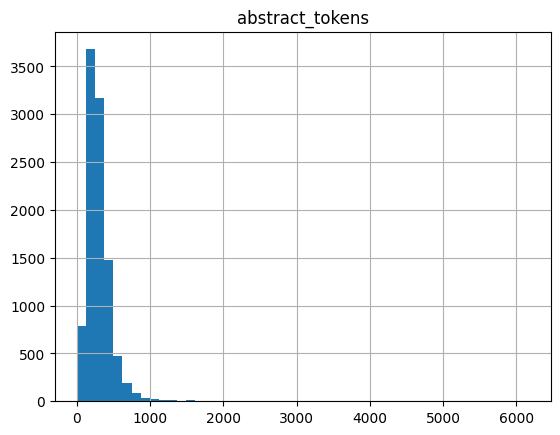

In [10]:
sample.hist('abstract_tokens', bins=50)
#sample.hist('results_tokens', bins=50)

## Chunking
This part is only for results and conclusions.
Since abstracts are almost all under 1024 tokens (our chunk size) and all under the model's context size, we don't chunk them.

In [35]:
from langchain_text_splitters import SentenceTransformersTokenTextSplitter

In [53]:
splitter = SentenceTransformersTokenTextSplitter(model_name=model_name, tokens_per_chunk=1024, chunk_overlap=100) 

In [54]:
splitter.model_name

'Qwen/Qwen3-Embedding-0.6B'

In [59]:
splitter.count_tokens(s)

TypeError: SentenceTransformersTokenTextSplitter.count_tokens() takes 1 positional argument but 2 were given

In [64]:
def merge_sections(row):
    s = ''
    if row['results']:
        s += "## RESULTS\n" + row['results']
    if s and row['discussion']:
        s += '\n\n'
    if row['discussion']:
        s += "## DISCUSSION\n" + row['discussion']
    return s

In [65]:
row = df.iloc[0]

In [67]:
row

results       Germplasm accessions had variability on each c...
discussion    (619), 10515 (Siregi), 10551 (Logawa), dan 105...
Name: W3003650968, dtype: object

In [160]:
def process_row(idx, row):
    text = merge_sections(row)
    chunks = splitter.split_text(text)
    return [(idx,i,c) for i, c in enumerate(chunks)]

In [148]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed

In [173]:
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_row, idx, row) for idx, row in df.iterrows()]

    results = []
    for future in tqdm(futures, total=len(df), desc="Processing rows"):
        results += future.result()

Processing rows:   0%|          | 0/585775 [00:00<?, ?it/s]

In [174]:
len(results)

2703358

In [179]:
cdf = pd.DataFrame(results, columns=['openalex_id', 'chunk_idx', 'text'])

In [180]:
cdf.head()

,openalex_id,chunk_idx,text
0,W3003650968,0,RESULTS\nGermplasm accessions had variability...
1,W3003650968,1,ness deviation\nInformation: |loading| ≥ 0.4 w...
2,W3003650968,2,\nLWR\nWD\nT\nMD\nAC\nGT\nGC\nSD\nLoading valu...
3,W3003650968,3,"548, 10591, 10474, dan 10550. For developing l..."
4,W4394796190,0,RESULTS\nConceptualizing Stress and Work Over...


In [178]:
cdf.oaid.nunique()

585756

In [182]:
cdf = cdf.set_index('openalex_id')

In [183]:
cdf.to_parquet('chunked_results_conclusions_585k_cs1024_ov100_qw3-06B.parquet')

## Embedding

In [67]:
cdf = df[['id', 'doi', 'title', 'abstract', 'publication_date', 'type']]
cdf['doi'] = cdf['doi'].astype('string')
#cdf = pd.read_parquet('chunked_results_conclusions_585k_cs1024_ov100_qw3-06B.parquet')

/tmp/ipykernel_80184/1980821186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['doi'] = cdf['doi'].astype('string')


In [32]:
import pyarrow as pa
import pyarrow.parquet as pq

In [33]:
prompt = """
Embed this extract from a scientific article.
Text was extracted raw from a PDF file and cleaned lightly.
It still contains quirks like headers, footers, page numbers or table residues that should have been removed.
Iignore them, as well as potential references/citations.
What interests us is the meaning: what, in plain English, are the main results and conclusions of the paper.
"""

prompt = """
Embed this abstract from a scientific publication.
Focus in particular on the results, findings and/or conclusions that may be cited.
We are less interested in introduction phrases and methods.
That means, you'll usually want to focus more on the end of the abstract than the beginning.
The end usage is a RAG-based scientific chatbot.
"""
prompt = prompt.strip()
prompt

"Embed this abstract from a scientific publication.\nFocus in particular on the results, findings and/or conclusions that may be cited.\nWe are less interested in introduction phrases and methods.\nThat means, you'll usually want to focus more on the end of the abstract than the beginning.\nThe end usage is a RAG-based scientific chatbot."

In [47]:
em = pd.read_parquet(output_file)

In [68]:
cdf = cdf.set_index('id').drop(em.id).reset_index()
len(cdf)

834336

In [69]:
pool = model.start_multi_process_pool()

chunk_size = 96
batch_size = 32
#output_file = 'embeddings_results_conclusions_585k_cs1024_ov100_qw3-06B.parquet'
#column = 'text'
#output_file = 'embeddings_abstracts_library_v1_cs1024_ov100_qw3-06B.parquet'
output_file = 'embeddings_abstracts_tmp.parquet'
column = 'abstract'

writer = None
schema = None

try:
    for i in tqdm(range(0, len(cdf), chunk_size), desc="Encoding..."):
        chunk = cdf.iloc[i:i + chunk_size].copy()
        
        # Encode the chunk using multi-process pool
        embeddings = model.encode(
            chunk[column].values, 
            pool=pool,
            prompt=prompt,
            batch_size=batch_size
        )
        
        # Create PyArrow table for this chunk
        chunk['embedding'] = [embeddings[i] for i in range(embeddings.shape[0])]
        table = pa.Table.from_pandas(chunk)
            
        # Initialize writer with schema from first chunk
        if writer is None:
            schema = table.schema
            writer = pq.ParquetWriter(output_file, schema)
        
        # Write chunk to parquet
        writer.write_table(table)
finally:
    writer.close()
    model.stop_multi_process_pool(pool)

print(f"Saved embeddings to {output_file}")    

Encoding...:   0%|          | 0/8691 [00:00<?, ?it/s]

Saved embeddings to embeddings_abstracts_tmp.parquet


In [70]:
em1 = pd.read_parquet(output_file)

In [71]:
em2 = pd.read_parquet('embeddings_abstracts_library_v1_cs1024_ov100_qw3-06B.parquet')

In [72]:
len(em1)

834336

In [73]:
len(em2)

1675580

In [74]:
len(df)

2509916

In [75]:
len(em1) + len(em2)

2509916

In [78]:
set(em1.id.values).intersection(em2.id.values)

set()

In [79]:
em = pd.concat([em1, em2])

In [82]:
em.to_parquet('tmp.parquet')

In [63]:
em.iloc[0].embedding.shape

(1024,)

In [66]:
len(em)

1675580

In [23]:
em.reset_index().set_index(['openalex_id', 'chunk_idx'])

text  \
openalex_id chunk_idx                                                      
W3003650968 0           RESULTS\nGermplasm accessions had variability...   
            1          ness deviation\nInformation: |loading| ≥ 0.4 w...   
            2          \nLWR\nWD\nT\nMD\nAC\nGT\nGC\nSD\nLoading valu...   
            3          548, 10591, 10474, dan 10550. For developing l...   
W4394796190 0           RESULTS\nConceptualizing Stress and Work Over...   
...                                                                  ...   
W4388621958 0           RESULTS\nTo validate the model prediction, we...   
            1           region. In\n130 the second underestimated hot...   
            2           effects of these features. It is furthermore\...   
            3          ol pollution will like impact the production o...   
            4          263, 105808 (2021) https://doi.org/10.1016/j.a...   

                                                               embedding  
openalex_id chunk_idx                                                     
W3003650968 0          [-0.0863, -0.00726, -0.002497, 0.0049, 0.01926...  
            1          [-0.0884, -0.01878, -0.00371, 0.004097, 0.0167...  
            2          [-0.0844, -0.01199, -0.006653, -0.013626, -0.0...  
            3          [-0.0656, -0.02927, -0.00984, -0.0324, 0.0244,...  
W4394796190 0          [0.0687, -0.05054, -0.003511, 0.0882, -0.05283...  
...                                                                  ...  
W4388621958 0          [0.003796, 0.02687, -0.005024, 0.0432, 0.00020...  
            1          [0.0003166, 0.02507, -0.00624, 0.0533, 0.036, ...  
            2          [-0.03128, 0.04898, -0.002747, 0.0711, 0.03204...  
            3          [-0.01072, 0.04926, -0.002228, 0.07294, 0.0295...  
            4          [-0.006233, 0.02354, -0.004646, 0.02138, -0.01...  

[2703358 rows x 2 columns]